# Exploring STFT Methods

## Importing Test Data, Util Libraries

In [35]:
from models.unet.unet_wrapped import STFTLayer, ISTFTLayer, AmpDbSpectLayer, AmpDbToAudioLayer
from utils.spectrogram_utils import SpectUtils

In [36]:
import tensorflow as tf

In [37]:
data_config = {
        "data_folder_path" : "./data",
        "folder_name" : "MS-SNSD",
        "sample_rate" : 16000,
        "hop_length" : 256,
        "noise_level" : 0.1,
        "frame_length" : 256 * 4,
        "fft_length" : 256 * 4,
        "clean_vec_repeats" : 1
}

stft_config = {
    "hop_length" : 256,
    "noise_level" : 0.1,
    "frame_length" : 256 * 4,
    "fft_length" : 256 * 4,
    "window_func" : tf.signal.hann_window
}

In [38]:

su = SpectUtils(
    sampling_rate=data_config["sample_rate"],
    hop_length=data_config["hop_length"],
    frame_length=data_config["frame_length"],
    fft_length=data_config["fft_length"]
)

# testvec = su.load_into_numpy("./data/MS-SNSD/clean_train/p234_001.wav")

testvec = su.load_into_numpy("./data/MS-SNSD/clean_test/clnsp6.wav")

print(testvec.shape)

(201887,)


Benchmark: NumPy audio, without transformations.

In [39]:
su.save_numpy_as_wav(testvec, "./loaded_example.wav")

In [40]:
testvec_as_tens = tf.convert_to_tensor(testvec)

## Initial STFT Fun

In [85]:
funlayer = STFTLayer(stft_config=stft_config)
funspect = funlayer.call(testvec_as_tens)

In [87]:
real = tf.math.real(funspect)
imag = tf.math.imag(funspect)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Fun Real'}, xlabel='Time'>)

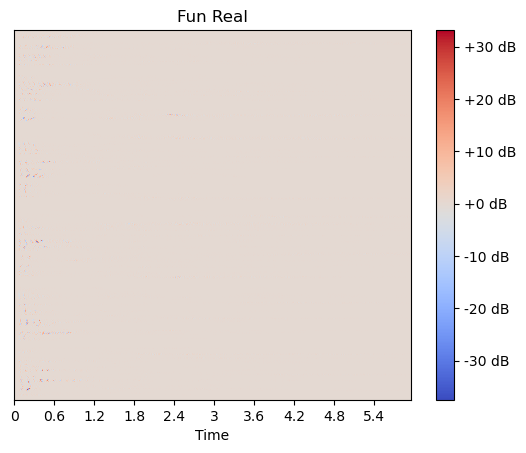

In [89]:
su.display_intensity_spectrogram(real, "Fun Real")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Fun Imaginary'}, xlabel='Time'>)

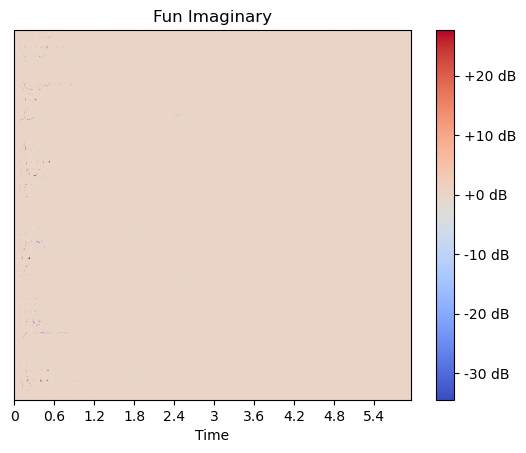

In [90]:
su.display_intensity_spectrogram(imag, "Fun Imaginary")

In [92]:
funbacklayer = ISTFTLayer(stft_config=stft_config)
recovered_fun_audio = funbacklayer.call(funspect)
su.save_numpy_as_wav(recovered_fun_audio, "./recovered_fun.wav")

In [93]:
funspect_depeeled = tf.complex(real, imag)
recovered_fun_depeeled = funbacklayer.call(funspect_depeeled)
su.save_numpy_as_wav(recovered_fun_depeeled, "./depeeled.wav")

In [48]:
# Borrowed from https://github.com/timsainb/tensorflow2-generative-models/blob/master/7.0-Tensorflow-spectrograms-and-inversion.ipynb

def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))

def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)

## Why Use the Decibel Scale?

In [41]:
testlayer = STFTLayer(stft_config=stft_config)
spectens = testlayer.call(testvec_as_tens)

In [42]:
real = tf.math.real(spectens)
imag = tf.math.real(spectens)

In [43]:
real

<tf.Tensor: shape=(785, 513), dtype=float32, numpy=
array([[-5.2738087e-03, -3.4496572e-02,  7.9076305e-02, ...,
         3.3232942e-04, -7.4062869e-04,  1.3150342e-03],
       [-3.5953820e-02,  9.6058980e-02, -1.7742907e-01, ...,
        -1.0924786e-04, -1.2649447e-03,  2.2753105e-03],
       [ 3.7881874e-02, -8.7959714e-02,  1.2759021e-01, ...,
         5.6608766e-04, -1.1768825e-03,  1.8592775e-03],
       ...,
       [-1.4187221e-01,  4.8399527e-02,  2.0503525e-02, ...,
         5.0690840e-03, -1.2873003e-02,  2.4118137e-02],
       [ 1.0914544e-01,  4.7915080e-03, -1.6622269e-01, ...,
        -1.1010230e-02,  1.7090375e-03,  4.9566105e-03],
       [ 3.7039304e-01, -2.2294985e-01,  1.9643530e-01, ...,
         7.8739002e-03,  5.7508945e-03, -7.7705532e-03]], dtype=float32)>

In [44]:
imag

<tf.Tensor: shape=(785, 513), dtype=float32, numpy=
array([[-5.2738087e-03, -3.4496572e-02,  7.9076305e-02, ...,
         3.3232942e-04, -7.4062869e-04,  1.3150342e-03],
       [-3.5953820e-02,  9.6058980e-02, -1.7742907e-01, ...,
        -1.0924786e-04, -1.2649447e-03,  2.2753105e-03],
       [ 3.7881874e-02, -8.7959714e-02,  1.2759021e-01, ...,
         5.6608766e-04, -1.1768825e-03,  1.8592775e-03],
       ...,
       [-1.4187221e-01,  4.8399527e-02,  2.0503525e-02, ...,
         5.0690840e-03, -1.2873003e-02,  2.4118137e-02],
       [ 1.0914544e-01,  4.7915080e-03, -1.6622269e-01, ...,
        -1.1010230e-02,  1.7090375e-03,  4.9566105e-03],
       [ 3.7039304e-01, -2.2294985e-01,  1.9643530e-01, ...,
         7.8739002e-03,  5.7508945e-03, -7.7705532e-03]], dtype=float32)>

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real STFT output'}, xlabel='Time'>)

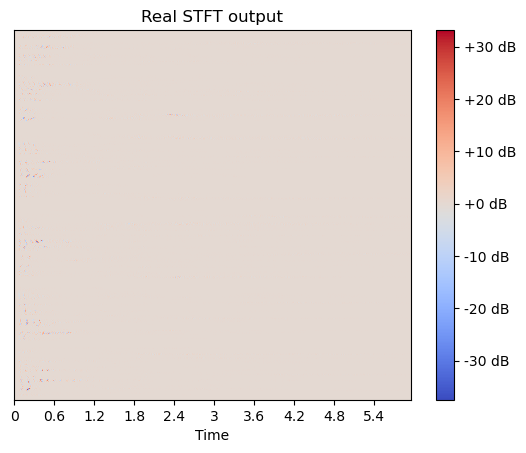

In [45]:
su.display_intensity_spectrogram(spec = real, title="Real STFT output")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Imaginary STFT output'}, xlabel='Time'>)

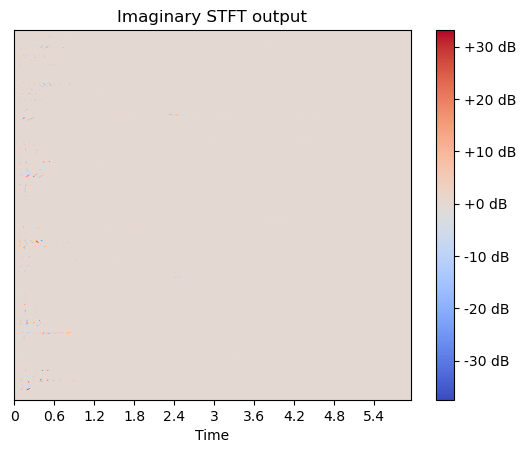

In [46]:
su.display_intensity_spectrogram(spec = imag, title="Imaginary STFT output")

In [47]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

In [69]:
real_db = _amp_to_db_tensorflow(real);

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real STFT output (dB)'}, xlabel='Time'>)

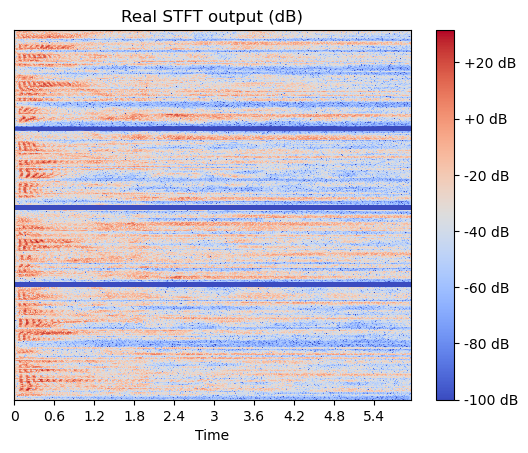

In [50]:
su.display_intensity_spectrogram(spec = real_db, title="Real STFT output (dB)")

In [51]:
imag_db = _amp_to_db_tensorflow(imag);

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real STFT output (dB)'}, xlabel='Time'>)

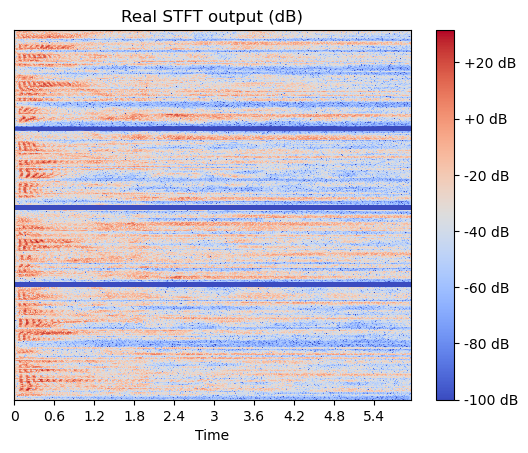

In [52]:
su.display_intensity_spectrogram(spec = imag_db, title="Real STFT output (dB)")

## Recovering Amplitude from Decibel Scale

In [53]:
recovered_real = _db_to_amp_tensorflow(real_db)
recovered_imag = _db_to_amp_tensorflow(imag_db)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real STFT output (dB)'}, xlabel='Time'>)

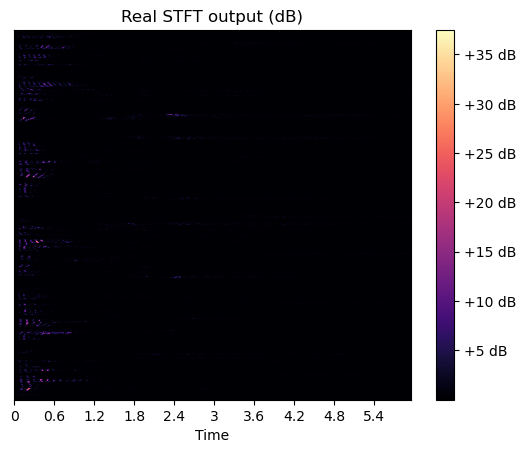

In [54]:
su.display_intensity_spectrogram(spec = recovered_real, title="Real STFT output (dB)")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real STFT output (dB)'}, xlabel='Time'>)

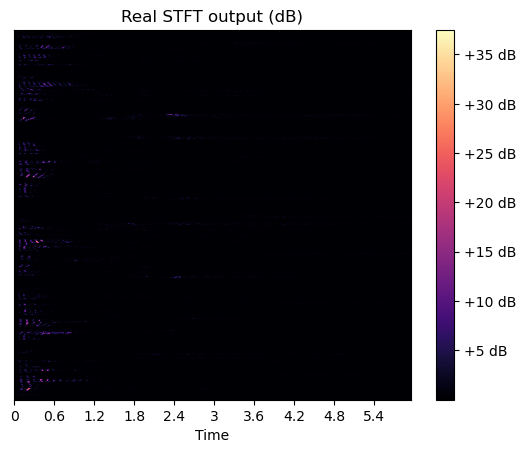

In [55]:
su.display_intensity_spectrogram(spec = recovered_imag, title="Real STFT output (dB)")

In [56]:
recovered_spect = tf.complex(recovered_real, recovered_imag)

In [57]:
inverse_layer = ISTFTLayer(stft_config=stft_config)
recovered_audio = inverse_layer.call(recovered_spect)

In [58]:
testvec.max()

0.5

In [59]:
recovered_audio.numpy().max()

0.12475284

In [60]:
su.save_numpy_as_wav(recovered_audio.numpy(), "./recovered.wav")

### Why is this spectrogram so different?

/var/folders/_9/9d6rqtrj1vv677x9kcj1cftc0000gp/T/ipykernel_11607/520999964.py:6: RuntimeWarning: invalid value encountered in log10
  y1 = np.log10(x)


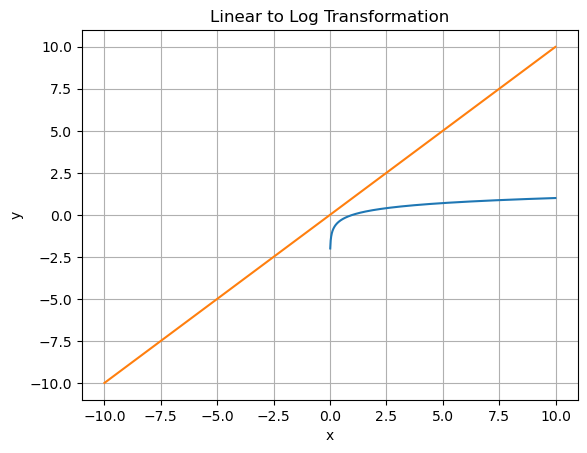

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = np.arange(-10, 10, 0.01)
y1 = np.log10(x)
y2 = x

fig, ax = plt.subplots()
ax.plot(x, y1)
ax.plot(x, y2)

ax.set(xlabel='x', ylabel='y',
       title='Linear to Log Transformation')
ax.grid()

fig.savefig("test.png")
plt.show()

## Complex dB Recovery vs. Raw Complex Recovery

In [61]:
recovered_spect_no_db = tf.complex(real, imag)
recovered_audio_no_db = inverse_layer.call(recovered_spect_no_db)

In [62]:
su.save_numpy_as_wav(recovered_audio_no_db, "./recovered_no_db.wav")

## Amplitude-Only Spectrograms

In [63]:
import tensorflow_io as tfio

Creates a complex-amplitude (real-valued) spectrogram: 

In [64]:
ampspectfunc = AmpDbSpectLayer(stft_config=stft_config, dB = False)
ampspect = ampspectfunc.call(testvec_as_tens)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Amplitude spectrogram, no dB conversion'}, xlabel='Time'>)

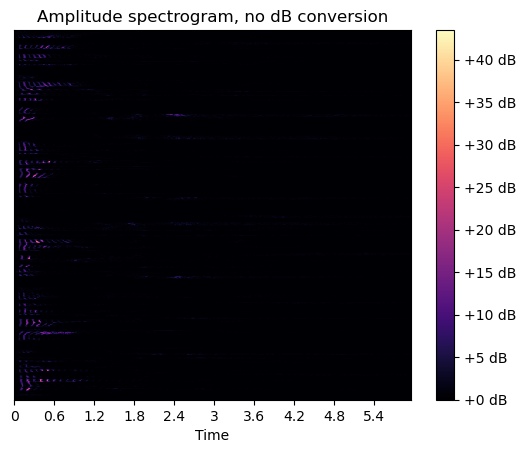

In [65]:
su.display_intensity_spectrogram(spec=ampspect, title="Amplitude spectrogram, no dB conversion")

In [66]:
ampspectbacklayer = AmpDbToAudioLayer(stft_config=stft_config, dB=False)
amprecovered = ampspectbacklayer.call(ampspect)

In [68]:
su.save_numpy_as_wav(amprecovered, "./amp-recovered.wav")

## Amplitude -> Decibel Spectrograms

In [71]:
ampsepctdblayer = AmpDbSpectLayer(stft_config=stft_config, dB=True)
ampspectdb = ampsepctdblayer.call(testvec_as_tens)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Decibel Spectrogram from Amplitude Spectrogram'}, xlabel='Time'>)

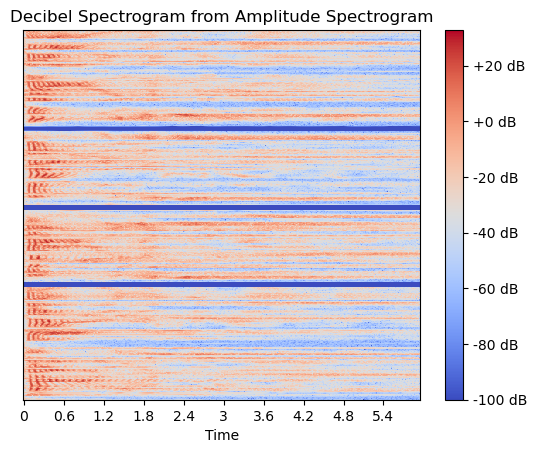

In [72]:
su.display_intensity_spectrogram(spec=ampspectdb, title="Decibel Spectrogram from Amplitude Spectrogram")

In [82]:
ampspectdbbacklayer = AmpDbToAudioLayer(
    stft_config=stft_config, 
    dB=True,
    halve=False,
    iters=60
)

In [83]:
dbamplitude_recovered = ampspectdbbacklayer.call(ampspectdb)

In [84]:
su.save_numpy_as_wav(dbamplitude_recovered, "./dbamplitude.wav")